In [63]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

from forex.pre_training_data_prep.config import config

In [2]:
config

{'database_name': 'django',
 'dag_id': 'NEW_prepare_forex_data',
 'list_data_columns': ['return', 'volatility', 'volume', 'lhc_mean'],
 'list_data_columns_no_scale': ['sin_24', 'cos_24'],
 'n_back': 180,
 'n_forward': 30,
 'offset': 1,
 'n_step': 10,
 'tz_name': 'US/Eastern',
 'price_type_name': 'mid',
 'instrument_name': 'EUR/USD',
 'interval_name': 'Minute',
 'retries_pull_forex_data': 1,
 'retry_delay_minutes_pull_forex_data': 5,
 'cutoff_max_consec_nans': 2,
 'cutoff_total_nan_count': 5,
 'shuffle_random_seed': 42,
 'train_val_test_split': [0.7, 0.15, 0.15],
 'shuffle_X_train_and_val': True,
 'directory_output': '/home/emily/Desktop/projects/test/badass-data-science/badassdatascience/forecasting/deep_learning/forex/output',
 'filename_candlesticks_query_results': 'candlesticks_query_results.parquet',
 'filename_timezone_added': 'candlesticks_timezone_added.parquet',
 'filename_offset': 'candlesticks_timezone_weekday_offset.parquet',
 'filename_weekday_shift_merged': 'candlesticks_w

In [ ]:
        stat_function_to_name_map = {
            np.mean : 'Mean',
            np.median : 'Median',
        }

In [3]:
filename_train_val_test_dict = '/home/emily/Desktop/projects/test/badass-data-science/badassdatascience/forecasting/deep_learning/forex/output/dict_final_numpy.pickled'

In [364]:
import datetime
import pytz

class TimeSeries():

    def __init__(self, filename_train_val_test_dict, config):

        with open(filename_train_val_test_dict, 'rb') as fff:
            train_val_test_dict = pickle.load(fff)

        self.config = config
        self.features_list = train_val_test_dict['features']['features_list']
        self.features_name_to_index = train_val_test_dict['features']['features_index_lookup']['name_to_index']
        self.features_index_to_name = train_val_test_dict['features']['features_index_lookup']['index_to_name']
        self.matrices = train_val_test_dict['matrices']
        self.timestamps = train_val_test_dict['list_of_timestamps']
        
       
        # need to refactor this
        self.stat_function_to_name_map = {
            np.mean : 'Mean',
            np.median : 'Median',
        }

    def get_feature_index_from_feature_name(self, feature_name = 'lhc_mean'):
        return self.features_name_to_index[feature_name]
    
    def get_X_for_a_row(self, set_name = 'train', feature_name = 'lhc_mean', row_index = 0):
        return self.matrices[set_name]['X'][row_index, :, self.get_feature_index_from_feature_name(feature_name = feature_name)]

    def get_y_for_a_row(self, set_name = 'train', feature_name = 'lhc_mean', row_index = 0):
        return self.matrices[set_name]['y'][row_index, :, self.get_feature_index_from_feature_name(feature_name = feature_name)]

    def get_y_summary_statistic_array(self, set_name = 'train', feature_name = 'lhc_mean', function = np.mean):
        y_temp = self.matrices[set_name]['y'][:, :, self.get_feature_index_from_feature_name(feature_name = feature_name)]
        return function(y_temp, axis = 1)
    
    def plot_it(
        self,
        index_panel = 0,
        feature_name = 'lhc_mean',
        summary_statistic_function = np.mean,
        predicted_y = None,
        marker = 'o',
        markersize = 10,
    ):
        static_function_name = self.stat_function_to_name_map[summary_statistic_function]
        
        X_test = self.get_X_for_a_row(set_name = 'test', feature_name = feature_name, row_index = index_panel)
        y_test = self.get_y_for_a_row(set_name = 'test', feature_name = feature_name, row_index = index_panel)

        X_range = np.arange(0, config['n_back'])
        y_range = np.arange(config['n_back'], (config['n_back'] + config['n_forward']))

        #labels_xticks = list(X_range - config['n_back'])
        #labels_xticks.extend(list(y_range - config['n_back']))
        #labels_xticks = np.array(labels_xticks)
        #labels_xticks = labels_xticks[::10]  # hard coded
        #xticks = labels_xticks + config['n_back']
        
        y_summary_statistic_value = self.get_y_summary_statistic_array(set_name = 'test', feature_name = feature_name)[index_panel]

        plt.figure()
        plt.plot(X_range, X_test, label = 'Known X')
        plt.plot(y_range, y_test, label = 'Known Y')
        plt.plot(y_range, [y_summary_statistic_value] * config['n_forward'], label = static_function_name + '(Known Y)')
        plt.plot([config['n_back']], y_test[0], marker = marker, markersize = markersize, label = 'Trade Execution Time')
        
        plt.ylabel(feature_name.replace('_', ' ') + ' (scaled)')
        plt.xlabel('Minutes')
        #plt.xticks(ticks = xticks, labels = labels_xticks)
        
        plt.legend()
        plt.tight_layout()
        plt.show()
        plt.close()

In [365]:
ts = TimeSeries(filename_train_val_test_dict, config)

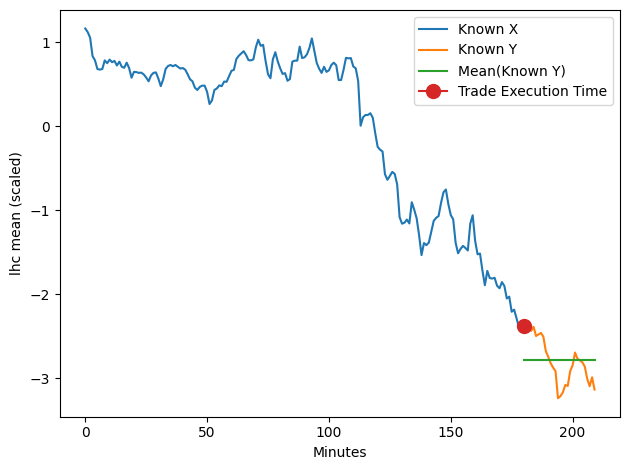

In [363]:
ts.plot_it(index_panel = 2000)